This notebook contains the analysis of the phone sensors with 10% population usage with the ShakeAlert performance. 

It includes the following information:

* Evaluation of the events with 4 SA triggers. 
    * 375 events from SA detected events
    * Using the first 4 triggers (from both system), comparing to only use SA

In [551]:
import pandas as pd
import numpy as np
import pickle
import glob
import os
import math
import pytz
import matplotlib.pyplot as plt
from geo_utils import calculate_dist
import utils

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

plt.style.use('seaborn-poster')

In [2]:
myshake_network_detection = pd.read_pickle('../data/myshake_detection_results.pkl')

# Get ShakeAlert messages
filename = '../data/shakeAlert/old_without_in_and_out/alerts2016.txt'
df_alert_2016, df_sa_trig_2016 = utils.read_alert_data(filename, False)
filename = '../data/shakeAlert/old_without_in_and_out/alerts2018.txt'
df_alert_2018, df_sa_trig_2018 = utils.read_alert_data(filename, False)

df_alert = pd.concat([df_alert_2016, df_alert_2018])
df_sa_trig = {**df_sa_trig_2016, **df_sa_trig_2018}

In [39]:
pickle.dump(df_sa_trig, open('shake_alert_trigger_dict_from_Ivan.pkl', 'wb'))

## Compare the results with MyShake simulated triggers

In [136]:
# get the first 4 triggers in SA
count = 0
for evid, item in df_sa_trig.items():
    if evid not in list(myshake_network_detection.keys()):
        continue
    df = item.drop_duplicates('sta', keep='first')
    if len(df) >3:
        count += 1
print(f'There are {count} events that has more than 4 SA triggers.')

There are 376 events that has more than 4 SA triggers.


In [20]:
len(myshake_network_detection)

785

In [650]:
class locator:

    def calculate_dist(self, lat1, lon1, lat2, lon2):
        '''
        This function calculate the distance on earth, assume earth is a sphere, 
        and earth's radius is 6371 km. 
        
        Input:
        lat1, lon1 - latitude, longitude of the first point.
        lat2, lon2 - latitude, longitude of the second point.
        
        Return:
        dist - distance between these two points in km.
        '''
    
        ## Convert latitude and longitude to
        ## spherical coordinates in radians.
        degrees_to_radians = math.pi / 180.0
    
        ## phi = 90 - latitude
        phi1 = (90.0 - lat1) * degrees_to_radians
        phi2 = (90.0 - lat2) * degrees_to_radians
    
        ## theta = longitude
        theta1 = lon1 * degrees_to_radians
        theta2 = lon2 * degrees_to_radians
    
        ## Compute spherical distance from spherical coordinates.
    
        ## For two locations in spherical coordinates
        ## (1, theta, phi) and (1, theta', phi')
        ## cosine( arc length ) =
        ##    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
        ## distance = rho * arc length
        cos = (math.sin(phi1) * math.sin(phi2) * math.cos(theta1 - theta2) +
                math.cos(phi1) * math.cos(phi2))
    
        if cos > 1.0:
            return 0
        else:
            arc = math.acos(cos)
            dist = arc * 6371.
            return dist

    def calculate_time_residual(self, lat, lon, t, evdp = 8.0):
        
        vs = 6.1
        n = len(trig_lat)

        dist = np.array(list(map(self.calculate_dist, trig_lat, trig_lon, [lat]*n, [lon]*n)))
    
        dist_hypo = np.sqrt(dist**2 + evdp**2)
    
        t_s = dist_hypo / vs
    
        t_obs = (trig_t - t)   # in seconds
        err = np.abs(t_s - t_obs)
        return [sum(err), lat, lon, t]

    # need an array: 0 index, 1 time, 2 lat, 3 lon
    def grid_search_loc(self, dist_time_arr, t0, eq_lat_0, eq_lon_0, evdp = 8.0):
        
        # forming grid 
        lat_grid = np.arange(eq_lat_0 - 1, eq_lat_0 + 1, 0.05)   # grid with 0.05 deg spacing
        lon_grid = np.arange(eq_lon_0 - 1, eq_lon_0 + 1, 0.05)
        t_grid = np.arange(t0 - 15, t0, 0.5)   # search for an origin time (nearest second) between initial trigger time and 15 sec before
        global trig_lat, trig_lon, trig_t
        trig_lat = dist_time_arr[:, 1]
        trig_lon = dist_time_arr[:, 2]
        trig_t = dist_time_arr[:, 0]
        error_mat = []
    
        ## simplify the grid search 
        count = 0
        lats, lons, times = np.meshgrid(lat_grid, lon_grid, t_grid)

        error_mat = list(map(self.calculate_time_residual, lats.ravel(), lons.ravel(), times.ravel()))
        
        error_mat = np.array(error_mat)
        return error_mat[np.argmin(error_mat[:, 0])]

In [705]:
from datetime import datetime, timezone
import mgrs
from collections import Counter

local_tz = pytz.timezone('US/Pacific')

def utc_to_local(utc_dt):
    local_dt = utc_dt.replace(tzinfo=pytz.utc).astimezone(local_tz)
    return local_tz.normalize(local_dt) # .normalize might be unnecessary

def convert_to_mgrs(lats, lons, MGRSPrecision = 1):
    '''
     MGRSPrecision = 1, resolution is 10 km
     MGRSPrecision = 2, resolution is 1 km
     MGRSPrecision = 3, resolution is 100 m
     MGRSPrecision = 4, resolution is 10 m
     MGRSPrecision = 5, resolution is 1 m
    '''
    # Note, if you use MGRSPrecision = 1, it returns the center of the cell. I tested using the map visualization: https://mappingsupport.com/p/coordinates-mgrs-google-maps.html
    m = mgrs.MGRS()
    inDegrees = True
    MGRSPrecision=MGRSPrecision
    n = len(lats)
    c = list(map(m.toMGRS, lats, lons, [True]*n, [MGRSPrecision]*n))

    return c

def sliding_window_triggers(start_time, end_time, df_trig, MGRSPrecision):
    
    df = df_trig[(
        df_trig.tt_rel_with_latency >start_time) & (df_trig.tt_rel_with_latency <= end_time)]
    
    cell_names = convert_to_mgrs(df.latitude, df.longitude, MGRSPrecision = MGRSPrecision)
    df = df.assign(cell=cell_names)
    
    return df

def get_ratio(trig_cell, steady_cell, min_steady):
    
    ratio_dict = {}
    for cellid, n_trig in trig_cell.items():
        n_steady = steady_cell[cellid]
        if n_steady < min_steady:
            ratio = 0
        else:
            ratio = n_trig/n_steady
            
        ratio_dict[cellid] = ratio
        
    return ratio_dict

def get_time_when_pass_threshold(df_trig, steady_phones, df_sa_trigs,
                                 win_length, win_step, MGRSPrecision,
                                 origin_time,
                                 min_steady = 10, ratio_threshold = 0.3,
                                 ):
    m = mgrs.MGRS()
    steady_phones = np.array(steady_phones)
    steady_phones_cell_dict = Counter(convert_to_mgrs(steady_phones[:, 0], steady_phones[:, 1], MGRSPrecision=MGRSPrecision))
    
    all_trigs = []
    for start_time in np.arange(0-win_length, 30, win_step):
        end_time = round(start_time + win_length, 1)
        df_trig_select = sliding_window_triggers(
            start_time, end_time, df_trig, MGRSPrecision=MGRSPrecision)
        
        # get number of SA triggers
        df_sa_trig_select = df_sa_trigs[(df_sa_trigs.tt > start_time) & (df_sa_trigs.tt <= end_time)]
        n_sa_trig = len(df_sa_trig_select)
        trig_cell_dict = Counter(df_trig_select.cell.values)
        ratio_dict = get_ratio(trig_cell_dict, steady_phones_cell_dict, min_steady)
        
        ratios = np.array(list(ratio_dict.values()))
        
        n_cells_exceed = len(ratios[ratios>=ratio_threshold])
        
        if n_cells_exceed + n_sa_trig >= 4:
            
            # get the SA triggers
            if n_sa_trig > 0:
                for ix, row in df_sa_trig_select.iterrows():
                    all_trigs.append([row.trig_timestamp_s, row.lat, row.lon])
                
            # get all the cell aggregated triggers
            cellid_above_threshold = [key for key, ratio in ratio_dict.items() if ratio >= ratio_threshold]
            if n_cells_exceed > 0: 
                for cellid in cellid_above_threshold:
                    df_trig_in_cell = df_trig_select[df_trig_select.cell == cellid]
                    
                    # get the cell latitude and longitude
                    lat, lon = m.toLatLon(cellid)
                    # get the median trigger time
                    trig_time_list = []
                    for ix, row in df_trig_in_cell.iterrows():
                        trig_timestamp_s = origin_time + row.tt_rel_with_latency
                        trig_time_list.append(trig_timestamp_s)
                        
                    all_trigs.append([np.median(trig_timestamp_s), lat, lon])
                    
            break
        
    return end_time, all_trigs
        

In [414]:
groudtruth_path = '../data/ground_truth/'
simulation_path = '../data/simulation_data_10p/'

In [706]:
count = 0
quake_trig_before_SA_first_alert = {}
sa_4th_station_trigger_time = []
combined_4th_station_trigger_time = []
combined_4th_station_trigger_time_cell_level = []
evid_arr = []
event_loc_arr = []
event_mag_arr = []
event_time_arr = []

all_trigers_SA = []
all_trigers_SA_with_phone_trig = []
all_trigers_SA_with_cells = []
for ix, row in df_alert.iterrows():
    evid = row['evid']
    #if evid != 'ci37524376':
    #    continue
    if evid not in list(myshake_network_detection.keys()):
        continue
    
    count += 1
    # read in the data
    earthquake = pd.read_pickle(os.path.join(groudtruth_path, evid + '_ground_truth.pkl'))
    
    # read in the simulation data
    simulation_file = glob.glob(os.path.join(simulation_path, evid + '*_simulations.pkl'))[0]
    simulation_dict = pickle.load(open(simulation_file, 'rb'))
    
    orig_time, t_start, t_end = \
        utils.slice_time_from_eq_origin(
                earthquake,
                start_time_s_from_origin=-30,
                end_time_s_from_origin=60
                                       )
    df_trig_simu = simulation_dict[0]['df_trig']
    
    # get the triggers before the alert time
    alert_time = row.alert_time
    # use 7 km/s instead to have some buffer
    p_dist_km = alert_time * 7
    
    df_trig_simu_select = df_trig_simu[
        (df_trig_simu.dist_km < p_dist_km) & 
        (df_trig_simu.tt_rel_with_latency >0) & 
        (df_trig_simu.tt_rel_with_latency < alert_time)]
    
    # get the earthquake triggers
    quake_trigs = df_trig_simu_select[df_trig_simu_select.quake_label==1]
    n_quake_trig = len(quake_trigs)
    
    dt = datetime.strptime(earthquake['time'], '%Y-%m-%dT%H:%M:%S.%fZ')
    
    quake_trig_before_SA_first_alert[evid] = [utc_to_local(dt).hour,
                                              earthquake['latitude'],
                                              earthquake['longitude'], 
                                              earthquake['mag'],
                                              n_quake_trig]
    
    sa_trigs = df_sa_trig[evid]
    df = sa_trigs.drop_duplicates('sta', keep='first')
    # we have more than 4 triggered stations
    if len(df) >3:
        tmp_phone_sa_triggers = []
        df = df.sort_values('tt')
        # get the 4th trigger time
        tt_s_4th_station = round(df.iloc[3].tt, 1)
        sa_4th_station_trigger_time.append(tt_s_4th_station)
        
        # get the SA triggers for location
        sa_trigs_4_station = [[row.trig_timestamp_s, row.lat, row.lon] for ix, row in df.iloc[:4].iterrows()]
        
        # get all trigger times into the same array, note, we also add the latency to the simulated 
        # triggers
        all_trig_combine = sorted(np.concatenate((df.tt.values, quake_trigs.tt_rel_with_latency.values)))
        combined_4th_station_trigger_time.append(all_trig_combine[3])
        
        # put all the triggers from the phone and SA together and then get the first 4 triggers
        tmp_phone_sa_triggers = sa_trigs_4_station.copy()
        for ix, row in quake_trigs.iterrows():
            tmp_phone_sa_triggers.append([row.tt_rel_with_latency + orig_time, row.latitude, row.longitude])
        tmp_phone_sa_triggers.sort(key=lambda x: x[0])
        tmp_phone_sa_triggers = tmp_phone_sa_triggers[:4]
        
        all_cell_combined_time, all_trigs = get_time_when_pass_threshold(df_trig_simu, 
                                                              simulation_dict[0]['phones_steady'], df,
                             win_length=20, win_step=0.1, MGRSPrecision=1, origin_time=orig_time,
                             min_steady = 10, ratio_threshold = 0.3)
        #if all_cell_combined_time > tt_s_4th_station:
        #    print(all_cell_combined_time, tt_s_4th_station)
        #    print(df.tt)
        combined_4th_station_trigger_time_cell_level.append(all_cell_combined_time)
        
        evid_arr.append(evid)
        event_loc_arr.append([earthquake['latitude'], earthquake['longitude']])
        event_mag_arr.append(earthquake['mag'])
        event_time_arr.append(earthquake['time'])
        
        all_trigers_SA.append(sa_trigs_4_station)
        all_trigers_SA_with_phone_trig.append(tmp_phone_sa_triggers)
        all_trigers_SA_with_cells.append(all_trigs)
                
combined_4th_station_trigger_time = np.array(combined_4th_station_trigger_time)
combined_4th_station_trigger_time_cell_level = np.array(combined_4th_station_trigger_time_cell_level)
sa_4th_station_trigger_time = np.array(sa_4th_station_trigger_time)
evid_arr = np.array(evid_arr)
event_loc_arr = np.array(event_loc_arr)
event_mag_arr = np.array(event_mag_arr)
event_time_arr = np.array(event_time_arr)
all_trigers_SA = np.array(all_trigers_SA)
all_trigers_SA_with_phone_trig = np.array(all_trigers_SA_with_phone_trig)
all_trigers_SA_with_cells = np.array(all_trigers_SA_with_cells)


In [707]:
# There is one event from Ivan is wrong, the alert time is negative, we remove it
ix = sa_4th_station_trigger_time > 0
combined_4th_station_trigger_time = combined_4th_station_trigger_time[ix]
combined_4th_station_trigger_time_cell_level = combined_4th_station_trigger_time_cell_level[ix]
sa_4th_station_trigger_time = sa_4th_station_trigger_time[ix]
evid_arr = evid_arr[ix]
event_loc_arr = event_loc_arr[ix]
event_mag_arr = event_mag_arr[ix]
all_trigers_SA = all_trigers_SA[ix]
event_time_arr = event_time_arr[ix]
all_trigers_SA_with_phone_trig = all_trigers_SA_with_phone_trig[ix]
all_trigers_SA_with_cells = all_trigers_SA_with_cells[ix]

In [708]:
n_SA_events = len(all_trigers_SA)

(0, 25)

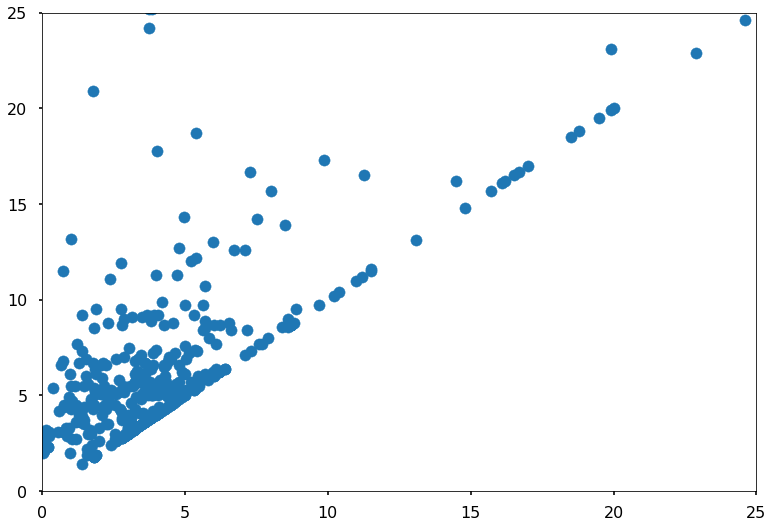

In [709]:
plt.scatter(combined_4th_station_trigger_time, sa_4th_station_trigger_time)
plt.xlim(0, 25)
plt.ylim(0, 25)

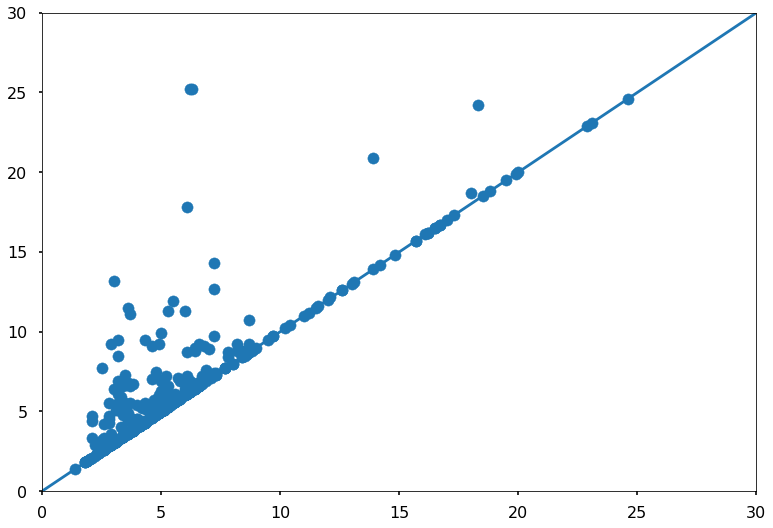

In [533]:
plt.scatter(combined_4th_station_trigger_time_cell_level, sa_4th_station_trigger_time)
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.plot(range(0, 31), range(0, 31))

In [710]:
diff_4th_trig_time = combined_4th_station_trigger_time - sa_4th_station_trigger_time
diff_4th_cell_time = combined_4th_station_trigger_time_cell_level - sa_4th_station_trigger_time

In [711]:
diff_4th_trig_time_improved = diff_4th_trig_time[diff_4th_trig_time!=0]
print(f'There are {len(diff_4th_trig_time_improved)} '
      f'({len(diff_4th_trig_time_improved)/n_SA_events*100:.1f}%) events improved, alert time improved '
      f'mean: {np.mean(diff_4th_trig_time_improved):.2f}, '
      f'median: {np.median(diff_4th_trig_time_improved):.2f}, '
      f'std: {np.std(diff_4th_trig_time_improved):.2f}')

There are 270 (72.0%) events improved, alert time improved mean: -3.08, median: -2.38, std: 3.17


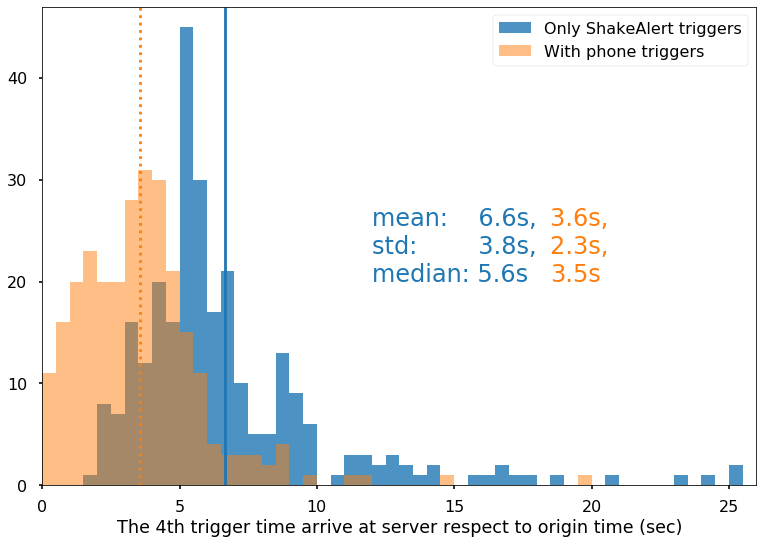

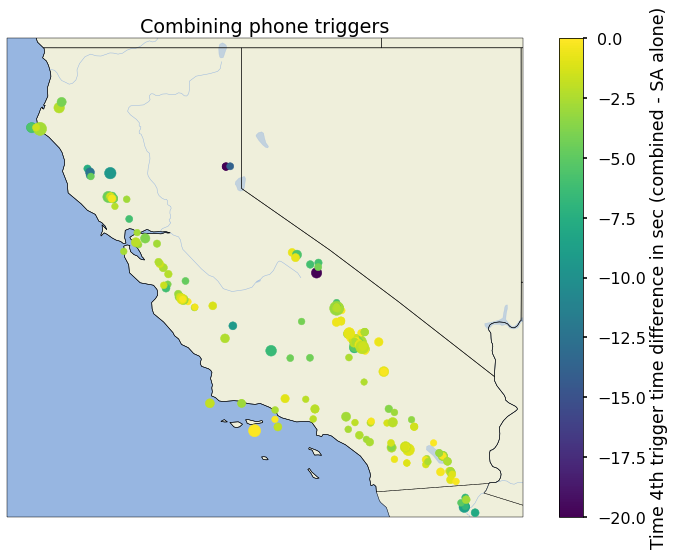

In [546]:
ix = diff_4th_trig_time!=0
plt.hist(sa_4th_station_trigger_time[ix], bins=np.arange(0, 26, 0.5), width=0.5,
         label='Only ShakeAlert triggers', alpha=0.8)
plt.hist(combined_4th_station_trigger_time[ix], bins=np.arange(0, 26, 0.5), width=0.5,
         alpha=0.5, label='With phone triggers')
plt.vlines(np.mean(sa_4th_station_trigger_time[ix]), 0, 47, color='#1f77b4')
plt.vlines(np.mean(combined_4th_station_trigger_time[ix]), 0, 47, linestyle=":", color='#ff7f0e')
plt.xlim(0, 26)
plt.ylim(0, 47)
plt.text(12, 20, (f'mean:    {np.mean(sa_4th_station_trigger_time[ix]):.1f}s, \n'
                  f'std:        {np.std(sa_4th_station_trigger_time[ix]):.1f}s, \n'
                  f'median: {np.median(sa_4th_station_trigger_time[ix]):.1f}s'),
         fontsize=24, color = '#1f77b4')

plt.text(18.5, 20, (f'{np.mean(combined_4th_station_trigger_time[ix]):.1f}s, \n'
                  f'{np.std(combined_4th_station_trigger_time[ix]):.1f}s, \n'
                  f'{np.median(combined_4th_station_trigger_time[ix]):.1f}s'),
         fontsize=24, color = '#ff7f0e')
plt.legend()
plt.xlabel('The 4th trigger time arrive at server respect to origin time (sec)')
plt.show()

plot_scatter_on_map(
    event_loc_arr[ix][:, 1],
    event_loc_arr[ix][:, 0],
    c=diff_4th_trig_time[ix],
    s=event_mag_arr[ix]**3,
    vmin = -20,
    vmax = 0,
    clabel='Time 4th trigger time difference in sec (combined - SA alone)',
    filename=None,
    title='Combining phone triggers')

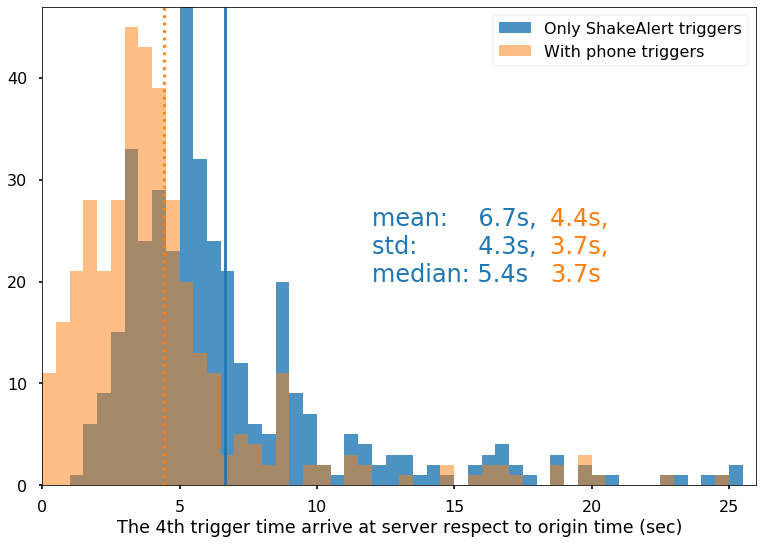

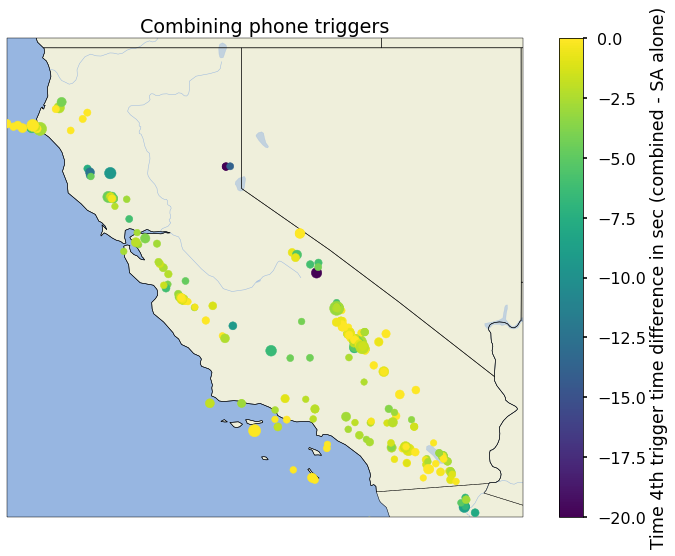

In [547]:
ix = diff_4th_trig_time!=10000
plt.hist(sa_4th_station_trigger_time[ix], bins=np.arange(0, 26, 0.5), width=0.5,
         label='Only ShakeAlert triggers', alpha=0.8)
plt.hist(combined_4th_station_trigger_time[ix], bins=np.arange(0, 26, 0.5), width=0.5,
         alpha=0.5, label='With phone triggers')
plt.vlines(np.mean(sa_4th_station_trigger_time[ix]), 0, 47, color='#1f77b4')
plt.vlines(np.mean(combined_4th_station_trigger_time[ix]), 0, 47, linestyle=":", color='#ff7f0e')
plt.xlim(0, 26)
plt.ylim(0, 47)
plt.text(12, 20, (f'mean:    {np.mean(sa_4th_station_trigger_time[ix]):.1f}s, \n'
                  f'std:        {np.std(sa_4th_station_trigger_time[ix]):.1f}s, \n'
                  f'median: {np.median(sa_4th_station_trigger_time[ix]):.1f}s'),
         fontsize=24, color = '#1f77b4')

plt.text(18.5, 20, (f'{np.mean(combined_4th_station_trigger_time[ix]):.1f}s, \n'
                  f'{np.std(combined_4th_station_trigger_time[ix]):.1f}s, \n'
                  f'{np.median(combined_4th_station_trigger_time[ix]):.1f}s'),
         fontsize=24, color = '#ff7f0e')
plt.legend()
plt.xlabel('The 4th trigger time arrive at server respect to origin time (sec)')
plt.show()

plot_scatter_on_map(
    event_loc_arr[ix][:, 1],
    event_loc_arr[ix][:, 0],
    c=diff_4th_trig_time[ix],
    s=event_mag_arr[ix]**3,
    vmin = -20,
    vmax = 0,
    clabel='Time 4th trigger time difference in sec (combined - SA alone)',
    filename=None,
    title='Combining phone triggers')

In [712]:
def get_err(est, gt_lat, gt_lng, gt_time):
    result = locator_model.grid_search_loc(est, np.min(est[:, 0]), 
                                       np.mean(est[:, 1]), np.mean(est[:, 2]))
    loc_err = locator_model.calculate_dist(gt_lat, gt_lng, result[1], result[2])
    time_err = result[3] - gt_time
    return loc_err, time_err

In [713]:
len(all_trigers_SA)

375

In [714]:
locator_model = locator()
location_err_compare = []
time_err_compare = []
for i, (SA_trigs, SA_with_phone, SA_with_cell) in enumerate(zip(all_trigers_SA, all_trigers_SA_with_phone_trig, all_trigers_SA_with_cells)):
    evid = evid_arr[i]
    #if evid != 'nc73143141':
    #    continue
    gt_lat = event_loc_arr[i][0]
    gt_lng = event_loc_arr[i][1]
    evtime_dt = datetime.strptime(event_time_arr[i].replace('Z',''), '%Y-%m-%dT%H:%M:%S.%f')
    gt_time = (evtime_dt - datetime(1970, 1, 1)).total_seconds()
    alert = df_alert[df_alert.evid == evid]
    sa_loc_err, sa_time_err = get_err(SA_trigs, gt_lat, gt_lng, gt_time)
    sa_loc_err_with_phone, sa_time_err_with_phone = get_err(SA_with_phone, gt_lat, gt_lng, gt_time)
    sa_loc_err_with_cell, sa_time_err_with_cell = get_err(np.array(SA_with_cell), gt_lat, gt_lng, gt_time)
    true_err = locator_model.calculate_dist(gt_lat, gt_lng, alert.est_evla, alert.est_evlo)
    #print(sa_loc_err, sa_loc_err_with_phone, sa_loc_err_with_cell, sa_time_err, sa_time_err_with_phone, sa_time_err_with_cell)
    location_err_compare.append([sa_loc_err, sa_loc_err_with_phone, sa_loc_err_with_cell])
    time_err_compare.append([sa_time_err, sa_time_err_with_phone, sa_time_err_with_cell])
    #if i == 1:
    #    break
    
location_err_compare = np.array(location_err_compare)
time_err_compare = np.array(time_err_compare)

(array([127.,  63.,  27.,  19.,  19.,  24.,  47.,  30.,  12.,   7.]),
 array([  0.27147243,  12.41217021,  24.55286799,  36.69356577,
         48.83426355,  60.97496134,  73.11565912,  85.2563569 ,
         97.39705468, 109.53775246, 121.67845025]),
 <a list of 10 Patch objects>)

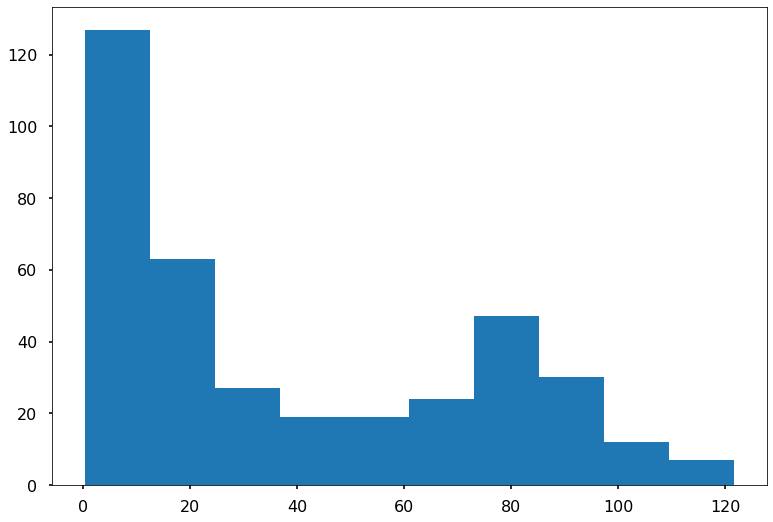

In [715]:
plt.hist(location_err_compare[:, 1])

In [703]:
ix = diff_4th_trig_time!=0
print(f'SA alone, mean: {np.mean(location_err_compare[:, 0][ix]):.1f}, '
      f'std: {np.std(location_err_compare[:, 0][ix]):.1f}, '
      f'median: {np.median(location_err_compare[:, 0][ix]):.1f}')


print(f'SA with phone triggers, mean: {np.mean(location_err_compare[:, 1][ix]):.1f}, '
      f'std: {np.std(location_err_compare[:, 1][ix]):.1f}, '
      f'median: {np.median(location_err_compare[:, 1][ix]):.1f}')

ix = diff_4th_cell_time!=0
print(f'SA alone, mean: {np.mean(location_err_compare[:, 0][ix]):.1f}, '
      f'std: {np.std(location_err_compare[:, 0][ix]):.1f}, '
      f'median: {np.median(location_err_compare[:, 0][ix]):.1f}')

print(f'SA with cell triggers, mean: {np.mean(location_err_compare[:, 2][ix]):.1f}, '
      f'std: {np.std(location_err_compare[:, 2][ix]):.1f}, '
      f'median: {np.median(location_err_compare[:, 2][ix]):.1f}')

SA alone, mean: 7.9, std: 12.4, median: 3.9
SA with phone triggers, mean: 46.7, std: 34.1, median: 41.5
SA alone, mean: 6.9, std: 9.1, median: 4.1
SA with cell triggers, mean: 26.7, std: 28.8, median: 13.9


In [717]:
ix = diff_4th_trig_time!=0
print(f'SA alone, mean: {np.mean(time_err_compare[:, 0][ix]):.1f}, '
      f'std: {np.std(time_err_compare[:, 0][ix]):.1f}, '
      f'median: {np.median(time_err_compare[:, 0][ix]):.1f}')


print(f'SA with phone triggers, mean: {np.mean(time_err_compare[:, 1][ix]):.1f}, '
      f'std: {np.std(time_err_compare[:, 1][ix]):.1f}, '
      f'median: {np.median(time_err_compare[:, 1][ix]):.1f}, '
      f'n: {len(time_err_compare[:, 1][ix]):d}, ')

ix = diff_4th_cell_time!=0
print(f'SA alone, mean: {np.mean(time_err_compare[:, 0][ix]):.1f}, '
      f'std: {np.std(time_err_compare[:, 0][ix]):.1f}, '
      f'median: {np.median(time_err_compare[:, 0][ix]):.1f}')

print(f'SA with cell triggers, mean: {np.mean(time_err_compare[:, 2][ix]):.1f}, '
      f'std: {np.std(time_err_compare[:, 2][ix]):.1f}, '
      f'median: {np.median(time_err_compare[:, 2][ix]):.1f}, '
      f'n: {len(time_err_compare[:, 1][ix]):d}, ')

SA alone, mean: 0.0, std: 1.8, median: 0.3
SA with phone triggers, mean: -5.3, std: 5.3, median: -4.4, n: 270, 
SA alone, mean: 0.2, std: 1.6, median: 0.3
SA with cell triggers, mean: -6.8, std: 6.8, median: -7.0, n: 140, 


(array([242.,  56.,  20.,  12.,   8.,  11.,  10.,  12.,   2.,   2.]),
 array([  0.27147243,  12.29127895,  24.31108548,  36.330892  ,
         48.35069852,  60.37050505,  72.39031157,  84.4101181 ,
         96.42992462, 108.44973114, 120.46953767]),
 <a list of 10 Patch objects>)

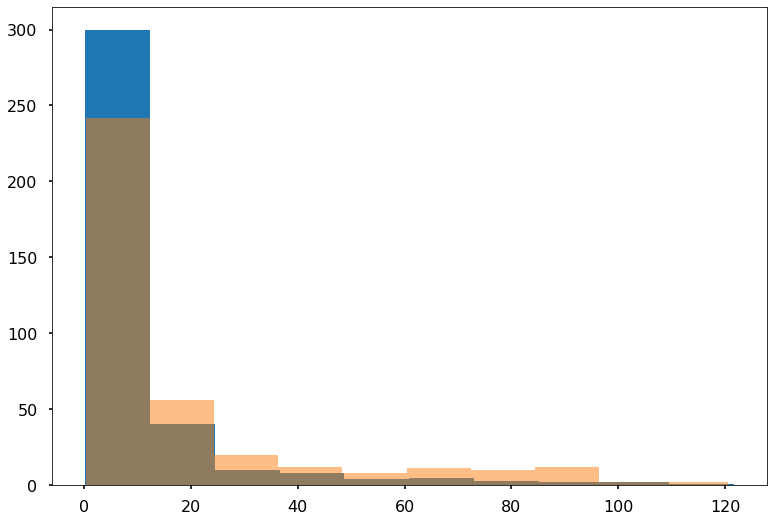

In [666]:
plt.hist(location_err_compare[:, 0])
plt.hist(location_err_compare[:, 2], alpha=0.5)

In [556]:
diff_4th_cell_time_improved = diff_4th_trig_time[diff_4th_cell_time!=0]
print(f'There are {len(diff_4th_cell_time_improved)} '
      f'({len(diff_4th_cell_time_improved)/n_SA_events*100:.1f}%) events improved, alert time improved '
      f'mean: {np.mean(diff_4th_cell_time_improved):.2f}, '
      f'median: {np.median(diff_4th_cell_time_improved):.2f}, '
      f'std: {np.std(diff_4th_cell_time_improved):.2f}')

There are 140 (37.3%) events improved, alert time improved mean: -4.35, median: -3.30, std: 3.64


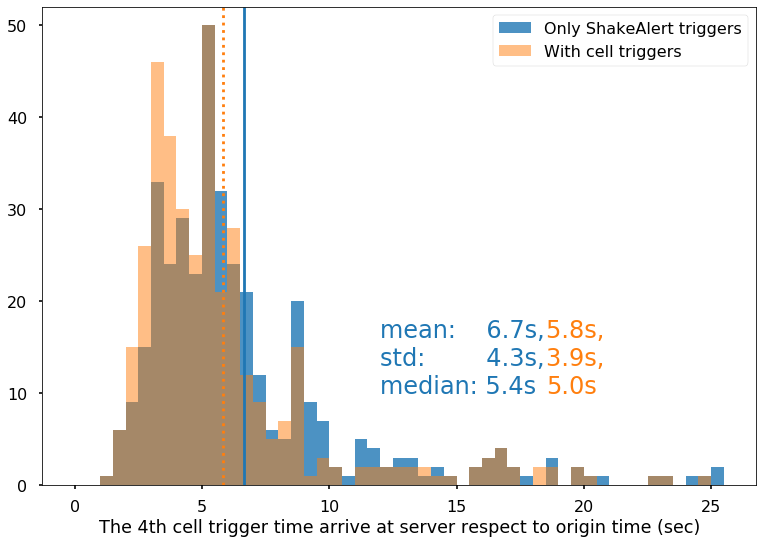

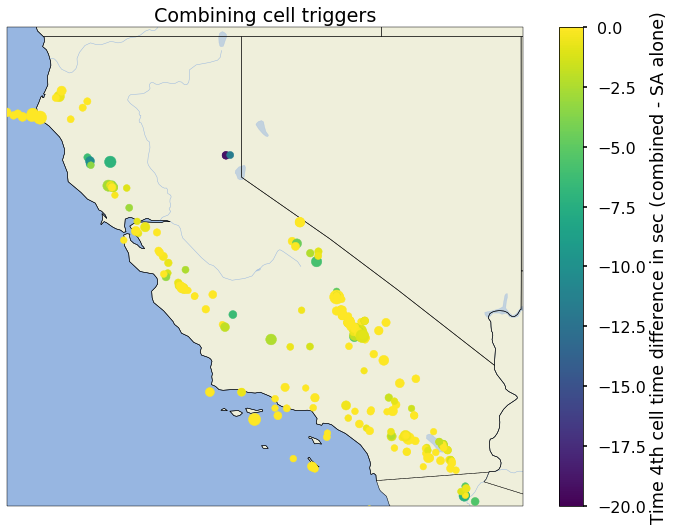

In [701]:
ix = diff_4th_cell_time!=10000
plt.hist(sa_4th_station_trigger_time[ix], bins=np.arange(0, 26, 0.5), width=0.5,
         label='Only ShakeAlert triggers', alpha=0.8)
plt.hist(combined_4th_station_trigger_time_cell_level[ix], bins=np.arange(0, 26, 0.5), width=0.5,
         alpha=0.5, label='With cell triggers')
plt.vlines(np.mean(sa_4th_station_trigger_time[ix]), 0, 52, color='#1f77b4')
plt.vlines(np.mean(combined_4th_station_trigger_time_cell_level[ix]), 0, 52, linestyle=":", color='#ff7f0e')
#plt.xlim(0, 26)
plt.ylim(0, 52)
plt.text(12, 10, (f'mean:    {np.mean(sa_4th_station_trigger_time[ix]):.1f}s, \n'
                  f'std:        {np.std(sa_4th_station_trigger_time[ix]):.1f}s, \n'
                  f'median: {np.median(sa_4th_station_trigger_time[ix]):.1f}s'),
         fontsize=24, color = '#1f77b4')

plt.text(18.5, 10, (f'{np.mean(combined_4th_station_trigger_time_cell_level[ix]):.1f}s, \n'
                  f'{np.std(combined_4th_station_trigger_time_cell_level[ix]):.1f}s, \n'
                  f'{np.median(combined_4th_station_trigger_time_cell_level[ix]):.1f}s'),
         fontsize=24, color = '#ff7f0e')
plt.legend()
plt.xlabel('The 4th cell trigger time arrive at server respect to origin time (sec)')
plt.show()

plot_scatter_on_map(
    event_loc_arr[ix][:, 1],
    event_loc_arr[ix][:, 0],
    c=diff_4th_cell_time[ix],
    s=event_mag_arr[ix]**3,
    vmin = -20,
    vmax = 0,
    clabel='Time 4th cell time difference in sec (combined - SA alone)',
    filename=None,
    title='Combining cell triggers')


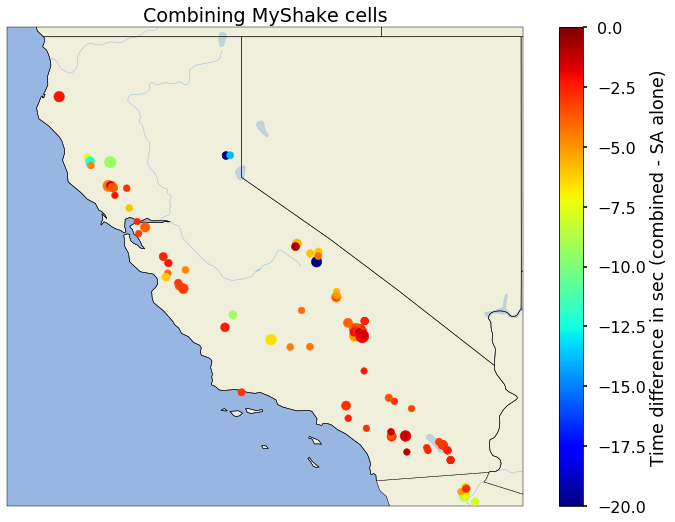

In [423]:
ix = diff_4th_cell_time!=0
plot_scatter_on_map(
    event_loc_arr[ix][:, 1],
    event_loc_arr[ix][:, 0],
    c=diff_4th_cell_time_improved,
    s=event_mag_arr[ix]**3,
    vmin = -20,
    vmax = 0,
    clabel='Time difference in sec (combined - SA alone)',
    filename=None,
    title='Combining MyShake cells',
    cmap=plt.cm.jet)

In [107]:
a = quake_trig_before_SA_first_alert_arr[:, -1]

len(a[a>10])

255

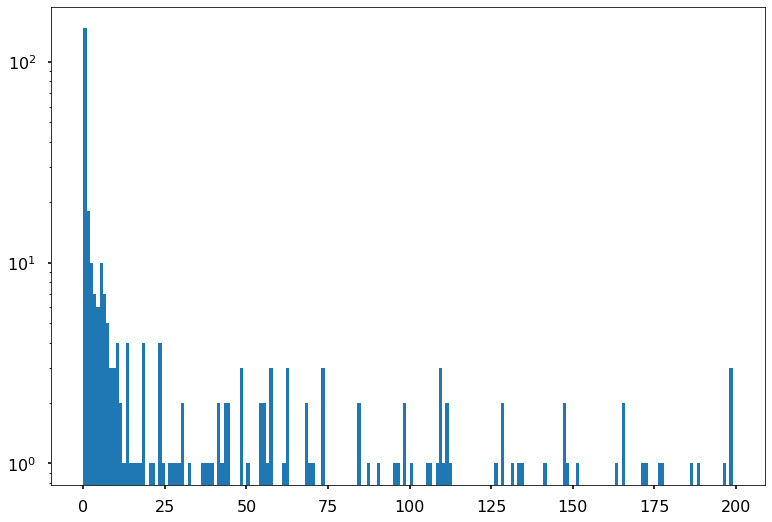

In [108]:
plt.hist(quake_trig_before_SA_first_alert_arr[:, -1], bins=np.arange(0, 200,1))
plt.yscale('log')

(array([23., 13., 22., 16., 15., 21., 16., 14., 15., 22., 26., 31., 16.,
        11., 17., 19., 26., 21., 23., 19., 26., 23., 40.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 23 Patch objects>)

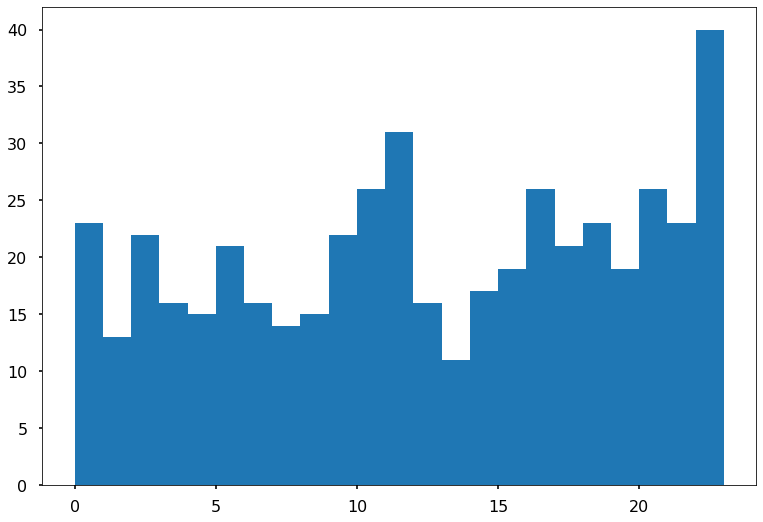

In [114]:
plt.hist(quake_trig_before_SA_first_alert_arr[:, 0], bins=np.arange(0, 24))

(array([261., 118.,  55.,  22.,   9.,   7.,   1.,   0.,   1.,   1.]),
 array([3.5 , 3.86, 4.22, 4.58, 4.94, 5.3 , 5.66, 6.02, 6.38, 6.74, 7.1 ]),
 <a list of 10 Patch objects>)

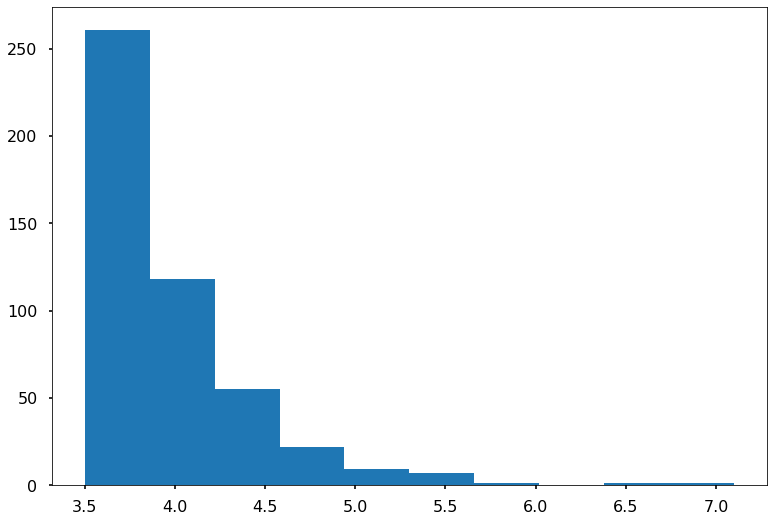

In [117]:
plt.hist(quake_trig_before_SA_first_alert_arr[:, 3])

## plot on the map

In [115]:
def plot_scatter_on_map(x,
                        y,
                        c,
                        s,
                        vmin = 0,
                        vmax = 100,
                        clabel=None,
                        filename=None,
                        resolution='50m',
                        title=None,
                        llat=32,
                        ulat=42.2,
                        llon=-125,
                        ulon=-114,
                       **kwarg):
    
    ax = plt.subplot(111, projection=ccrs.PlateCarree())
    ax.set_extent([llon, ulon, llat, ulat], crs=ccrs.PlateCarree())
        
    ax.add_feature(cfeature.LAND.with_scale(resolution))
    ax.add_feature(cfeature.OCEAN.with_scale(resolution))
    ax.add_feature(cfeature.COASTLINE.with_scale(resolution))
    ax.add_feature(cfeature.BORDERS.with_scale(resolution), linestyle=':')
    ax.add_feature(cfeature.LAKES.with_scale(resolution), alpha=0.5)
    ax.add_feature(cfeature.RIVERS.with_scale(resolution))
    ax.add_feature(cfeature.STATES.with_scale(resolution))
    
    cs = ax.scatter(x, y, marker='o',
                    s=s, c=c, vmin=vmin, 
                    vmax=vmax, zorder=10, **kwarg)
    if clabel is not None:
        cbar = plt.colorbar(cs)
        cbar.set_label(clabel)
    
    plt.title(title)
    
    if filename:
        plt.savefig(filename, bbox_inches = 'tight',
        pad_inches = 0.1)
    else:
        plt.show()

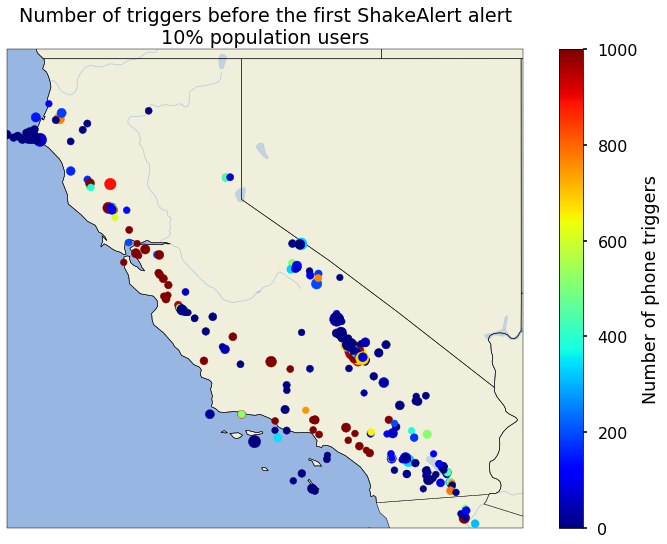

In [128]:
plot_scatter_on_map(
    quake_trig_before_SA_first_alert_arr[:, 2],
    quake_trig_before_SA_first_alert_arr[:, 1],
    c=quake_trig_before_SA_first_alert_arr[:, 4],
    s=quake_trig_before_SA_first_alert_arr[:, 3]**3,
    vmin = 0,
    vmax = 1000,
    clabel='Number of phone triggers',
    filename=None,
    title='Number of triggers before the first ShakeAlert alert\n10% population users',
    cmap=plt.cm.jet)

In [129]:
ix_larger_than_10 = quake_trig_before_SA_first_alert_arr[:, 4] >= 10

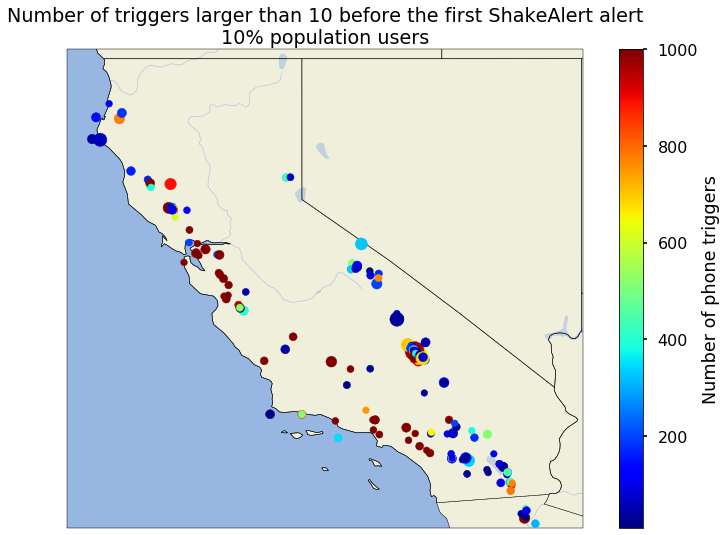

In [132]:
plot_scatter_on_map(
    quake_trig_before_SA_first_alert_arr[:, 2][ix_larger_than_10],
    quake_trig_before_SA_first_alert_arr[:, 1][ix_larger_than_10],
    c=quake_trig_before_SA_first_alert_arr[:, 4][ix_larger_than_10],
    s=quake_trig_before_SA_first_alert_arr[:, 3][ix_larger_than_10]**3,
    vmin = 10,
    vmax = 1000,
    clabel='Number of phone triggers',
    filename=None,
    title='Number of triggers larger than 10 before the first ShakeAlert alert\n10% population users',
    cmap=plt.cm.jet)

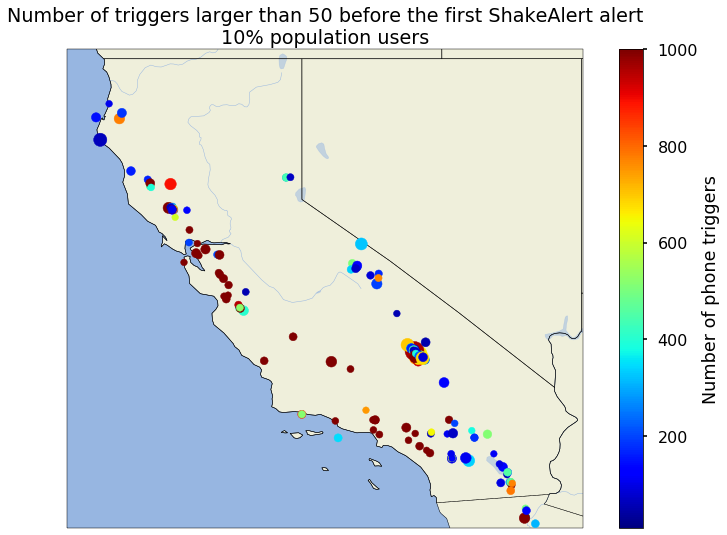

In [133]:
ix_larger_than_50 = quake_trig_before_SA_first_alert_arr[:, 4] >= 50
plot_scatter_on_map(
    quake_trig_before_SA_first_alert_arr[:, 2][ix_larger_than_50],
    quake_trig_before_SA_first_alert_arr[:, 1][ix_larger_than_50],
    c=quake_trig_before_SA_first_alert_arr[:, 4][ix_larger_than_50],
    s=quake_trig_before_SA_first_alert_arr[:, 3][ix_larger_than_50]**3,
    vmin = 10,
    vmax = 1000,
    clabel='Number of phone triggers',
    filename=None,
    title='Number of triggers larger than 50 before the first ShakeAlert alert\n10% population users',
    cmap=plt.cm.jet)